In [60]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import torch.nn.functional as F
import numpy as np

# torch.manual_seed(1)

EPOCH = 10
LR = 0.001
DOWNLOAD_MNIST = True

train_data = torchvision.datasets.MNIST(root='./mnist/', train=True, transform=torchvision.transforms.ToTensor(),
                                        download=DOWNLOAD_MNIST, )
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
print(train_data.train_data.shape)

train_x = torch.unsqueeze(train_data.train_data, dim=1).type(torch.FloatTensor) / 255.
train_y = train_data.train_labels
print(train_x.shape)

test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:2000] / 255.  # Tensor on GPU
test_y = test_data.test_labels[:2000]

torch.Size([60000, 28, 28])
torch.Size([60000, 1, 28, 28])


In [2]:
test_x.shape

torch.Size([2000, 1, 28, 28])

In [3]:
import matplotlib.pyplot as plt

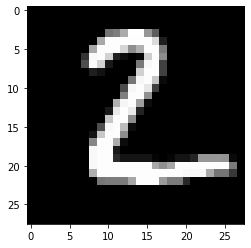

In [4]:
plt.imshow(test_x[1,0,:,:].numpy(), 'gray')

In [5]:
test_y[:10]

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [94]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(1, 32, 5, 1, 2),
                                         nn.BatchNorm2d(32),
                                         torch.nn.ReLU(),
                                         torch.nn.Conv2d(32, 16, 5, 1, 2),
                                         nn.BatchNorm2d(16),
                                         torch.nn.ReLU(),
                                         torch.nn.MaxPool2d(2, 2)) 
        self.dense = torch.nn.Sequential(torch.nn.Linear(14*14*16, 1024),
                                         nn.BatchNorm1d(1024),
                                         torch.nn.ReLU(),
                                         torch.nn.Dropout(p = 0.1),
                                         torch.nn.Linear(1024, 10),
                                         nn.BatchNorm1d(10),
                                         torch.nn.Linear(10, 10))
        
    def forward(self, x) :
        x = self.conv1(x)
        x = x.view(-1, 14*14*16)
        x = self.dense(x)
        return x

fc = CNN().cuda()
Acc = []
optimizer = torch.optim.Adam(fc.parameters(), lr=LR)
# loss_func = nn.MSELoss()
loss_func = nn.CrossEntropyLoss()

data_size = 20000
batch_size = 64

for epoch in range(EPOCH):
    random_indx = np.random.permutation(data_size)
    for batch_i in range(data_size // batch_size):
        indx = random_indx[batch_i * batch_size:(batch_i + 1) * batch_size]

        b_x = train_x[indx, :].cuda()
        b_y = train_y[indx].cuda()
#         print(b_x.shape)
#         print(b_y.shape)

        output = fc(b_x)
        loss = loss_func(output, b_y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch_i % 50 == 0:
            test_output = fc(test_x.cuda())
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            # pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = torch.sum(pred_y.cpu() == test_y).type(torch.FloatTensor) / test_y.size(0)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy(), '| test accuracy: %.3f' % accuracy)
            Acc.append(accuracy)
            
test_output = fc(test_x[:10].cuda())
pred_y = torch.max(test_output, 1)[1].data.squeeze()  # move the computation in GPU

print(pred_y, 'prediction number')
print(test_y[:10], 'real number')

Epoch:  0 | train loss: 2.4119 | test accuracy: 0.468
Epoch:  0 | train loss: 0.9417 | test accuracy: 0.934
Epoch:  0 | train loss: 0.6772 | test accuracy: 0.965
Epoch:  0 | train loss: 0.4473 | test accuracy: 0.973
Epoch:  0 | train loss: 0.3355 | test accuracy: 0.975
Epoch:  0 | train loss: 0.2911 | test accuracy: 0.980
Epoch:  0 | train loss: 0.2189 | test accuracy: 0.981
Epoch:  1 | train loss: 0.2195 | test accuracy: 0.976
Epoch:  1 | train loss: 0.1629 | test accuracy: 0.979
Epoch:  1 | train loss: 0.0874 | test accuracy: 0.984
Epoch:  1 | train loss: 0.0605 | test accuracy: 0.985
Epoch:  1 | train loss: 0.0947 | test accuracy: 0.982
Epoch:  1 | train loss: 0.0489 | test accuracy: 0.984
Epoch:  1 | train loss: 0.1540 | test accuracy: 0.980
Epoch:  2 | train loss: 0.0462 | test accuracy: 0.983
Epoch:  2 | train loss: 0.0432 | test accuracy: 0.986
Epoch:  2 | train loss: 0.0730 | test accuracy: 0.982
Epoch:  2 | train loss: 0.0415 | test accuracy: 0.984
Epoch:  2 | train loss: 0.02

In [95]:
test_output = fc(test_x[:10].cuda())
pred_y = torch.max(test_output, 1)[1].data.squeeze()  # move the computation in GPU

print(pred_y, 'prediction number')
print(test_y[:1], 'real number')

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], device='cuda:0') prediction number
tensor([7]) real number


In [96]:
test_output

tensor([[-0.4724, -2.7129,  0.7178,  2.4784, -1.0697,  0.1608,  0.2947,  9.3774,
          0.2319, -2.4415],
        [ 0.5155, -0.9804, 12.4559,  0.2334, -3.2105, -2.1188,  1.5936,  1.2220,
         -0.1094, -2.1437],
        [-1.6514,  8.6914, -1.6815,  0.5631, -2.2473,  1.4819, -1.2586,  0.4301,
          0.7055, -1.7792],
        [ 9.5026, -3.4176, -3.0087, -1.8318, -4.8210, -3.1106,  0.2264, -3.0399,
         -0.7634, -2.4892],
        [-1.1882, -2.6850, -2.4546, -0.2243,  8.4558, -1.3819, -2.6257, -2.9492,
         -0.3664, -0.7418],
        [-0.7368,  9.9990,  0.0432, -0.0221, -4.1387,  0.8102, -1.2294,  1.4968,
          0.3400, -1.3793],
        [-2.0180, -2.7792, -2.8343, -0.5079,  7.3939, -0.2476, -0.8500, -1.8755,
          0.4361, -1.8045],
        [-0.4266, -0.1346,  0.1072,  1.3031,  0.3414, -1.4529,  0.7662, -0.6506,
         -0.1565,  8.9901],
        [-1.7029, -3.2781, -1.4019, -0.3922, -0.5018,  7.3941,  3.5141, -0.1562,
          0.7425, -5.6997],
        [ 0.2475,  

In [97]:
test_x[:1].shape

torch.Size([1, 1, 28, 28])

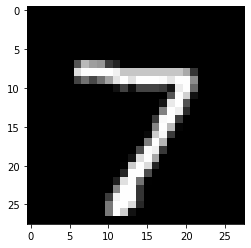

In [98]:
plt.imshow(test_x[:1].numpy().squeeze(), 'gray')

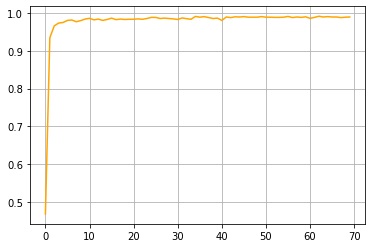

In [99]:
fig, ax = plt.subplots()
ax.grid(True, linestyle='-')
ax.plot(np.arange(len(Acc)), Acc, color='orange', linewidth=1.5)
plt.show()